In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import tensorflow as tf
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
image_size = 224
batch_size=24

In [ ]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)

In [ ]:
train_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/dataset/train'
labels = os.listdir(train_folder)
num_classes = len(set(labels))
train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
    )

Found 680 images belonging to 17 classes.


In [ ]:
validation_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/dataset/validation'
validation_generator = data_generator.flow_from_directory(
    validation_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
    )

Found 340 images belonging to 17 classes.


In [ ]:
test_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/dataset/test'
test_generator = data_generator.flow_from_directory(
    test_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
    )

Found 340 images belonging to 17 classes.


In [ ]:
# Create model
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
# model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False
# Compile model
# sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                34833     
Total params: 23,622,545
Trainable params: 34,833
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 5
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction


cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/gdrive/MyDrive/Projects/flower_category_prediction/best.hdf5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')
start = datetime.datetime.now()
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=NUM_EPOCHS,
    callbacks=[cb_checkpointer, cb_early_stopper])

end = datetime.datetime.now()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 86s 8s/step - loss: 3.6278 - accuracy: 0.0977 - val_loss: 2.4753 - val_accuracy: 0.2375
Epoch 2/100
10/10 [==============================] - 81s 8s/step - loss: 2.9181 - accuracy: 0.1743 - val_loss: 1.7759 - val_accuracy: 0.4958
Epoch 3/100
10/10 [==============================] - 76s 8s/step - loss: 2.2554 - accuracy: 0.3475 - val_loss: 1.4487 - val_accuracy: 0.6000
Epoch 4/100
10/10 [==============================] - 79s 8s/step - loss: 1.7629 - accuracy: 0.4968 - val_loss: 1.1135 - val_accuracy: 0.7042
Epoch 5/100
10/10 [==============================] - 80s 8s/step - loss: 1.4345 - accuracy: 0.5304 - val_loss: 0.9690 - val_accuracy: 0.7667
Epoch 6/100
10/10 [==============================] - 80s 8s/step - loss: 0.9532 - accuracy: 0.7102 - val_loss: 0.8312 - val_accuracy: 0.7917
Epoch 7/100
10/10 [==============================] - 80s 8s/step - loss: 1.0100 - accuracy: 0.7042 - val_loss: 0.7685 - val_accuracy: 0.8125
Epoch 8/100
1

In [ ]:
print('Execution time : ', end-start)

Execution time :  0:46:48.458072


In [ ]:
model.load_weights("/content/gdrive/MyDrive/Projects/flower_category_prediction/best.hdf5")

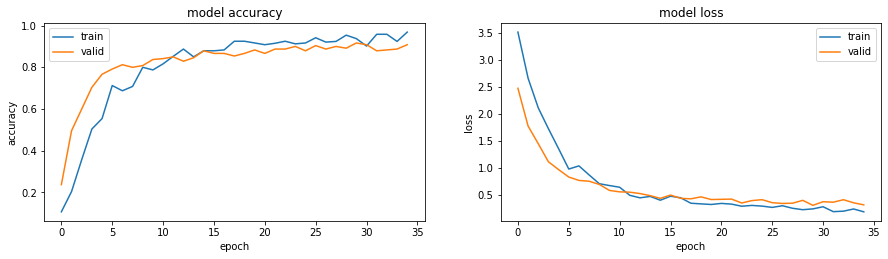

In [ ]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

In [ ]:
train_steps = train_generator.n // batch_size
val_steps = validation_generator.n // batch_size
test_steps = test_generator.n // batch_size
# evaluate performance on train, val & test datasets
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1, workers=3)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(validation_generator, steps=val_steps, verbose=1, workers=3)
print('Validation data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1, workers=3)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


28/28 [==============================] - 109s 4s/step - loss: 0.1224 - accuracy: 0.9836
Training data  -> loss: 0.122, acc: 0.984
14/14 [==============================] - 54s 4s/step - loss: 0.3731 - accuracy: 0.8810
Validation data -> loss: 0.373, acc: 0.881
14/14 [==============================] - 57s 4s/step - loss: 0.3404 - accuracy: 0.9048
Testing data   -> loss: 0.340, acc: 0.905


In [ ]:
def predict_category(img_file):
    img = load_img(img_file, target_size=(image_size, image_size))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    classes = model.predict_classes(x)
    return classes

In [ ]:
import os
classes_dict = train_generator.class_indices
test_img_path = test_folder
test_img_dirs = os.listdir(test_img_path)

x_test, y_test, y_pred, test_img_paths = [], [], [], []
for dir in test_img_dirs:
    img_file_names = os.listdir(f'{test_img_path}/{dir}')
    for img_file in img_file_names:
        test_img_paths.append(f'{dir}/{img_file}')
        img_path = f'{test_img_path}/{dir}/{img_file}'
        # print(img_path)
        x_test.append(load_img(img_path))
        category = predict_category(img_path)
        # print(category)
        pred = list(classes_dict.keys())[list(classes_dict.values()).index(category[0])]
        y_pred.append(pred)
        y_test.append(dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Bluebell/image_0246.jpg
Actual : Bluebell, Predicted : Tigerlily


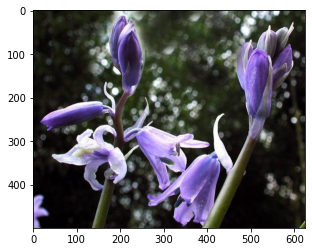

Bluebell/image_0263.jpg
Actual : Bluebell, Predicted : Snowdrop


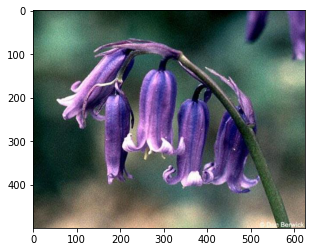

Bluebell/image_0277.jpg
Actual : Bluebell, Predicted : Tigerlily


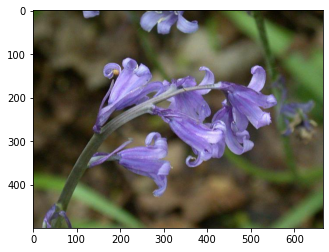

In [ ]:
def plot_wrong_predictions(x_test, y_test, y_pred, test_img_paths, n = 1):
    count = 0
    for input, prediction, actual, test_img_path in zip (x_test, y_pred, y_test, test_img_paths):
        if count < n:
            if prediction != actual:
                print(test_img_path)
                print(f'Actual : {actual}, Predicted : {prediction}')
                plt.imshow(input)
                plt.show()
                count+=1
plot_wrong_predictions(x_test, y_test, y_pred, test_img_paths, n = 3)